<a href="https://colab.research.google.com/github/kasiraodilli-a11y/Natural-Language-Processing/blob/main/DKR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# File Paths

TRAIN_PATH = "/content/drive/MyDrive/NLP project/train.tsv"
TRAIN_LABELS_PATH = "/content/drive/MyDrive/NLP project/TrainLabels.tsv"
DEV_PATH = "/content/drive/MyDrive/NLP project/dev.tsv"
DEV_LABELS_PATH = "/content/drive/MyDrive/NLP project/DevLabels.tsv"


# Load Data


train_df = pd.read_csv(TRAIN_PATH, sep="\t")
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH, sep="\t")

dev_df = pd.read_csv(DEV_PATH, sep="\t")
dev_labels_df = pd.read_csv(DEV_LABELS_PATH, sep="\t")

print("Train shape:", train_df.shape)
print("Train labels shape:", train_labels_df.shape)
print("Dev shape:", dev_df.shape)
print("Dev labels shape:", dev_labels_df.shape)



Train shape: (3991, 12)
Train labels shape: (19974, 2)
Dev shape: (500, 12)
Dev labels shape: (2499, 2)


In [ ]:
# Reshape Wide → Long (Filler1–Filler5)


def reshape_to_long(df):
    filler_cols = [c for c in df.columns if c.startswith("Filler")]
    long_df = df.melt(
        id_vars=[
            "Id", "Resolved pattern", "Article title", "Section header",
            "Previous context", "Sentence", "Follow-up context"
        ],
        value_vars=filler_cols,
        var_name="FillerNum",
        value_name="Candidate"
    )
    return long_df

long_train = reshape_to_long(train_df)
long_dev = reshape_to_long(dev_df)

print("Long train shape:", long_train.shape)
print("Long dev shape:", long_dev.shape)



Long train shape: (19955, 9)
Long dev shape: (2500, 9)


Merged train shape: (19955, 11)
Merged dev shape: (2500, 11)
Train label distribution:
 Label
0.0    12623
1.0     7331
Name: count, dtype: int64
Dev label distribution:
 Label
0.0    1584
1.0     915
Name: count, dtype: int64
Missing labels in train: (1, 11)
Missing labels in dev: (1, 11)


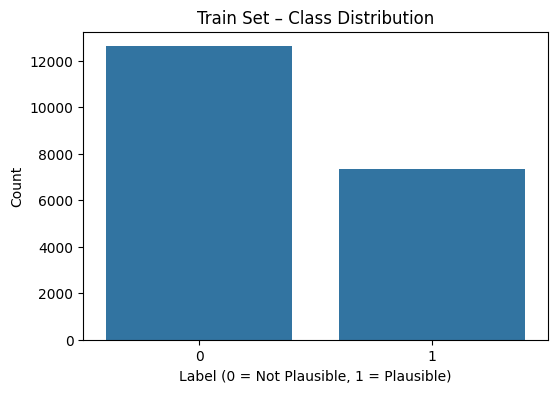

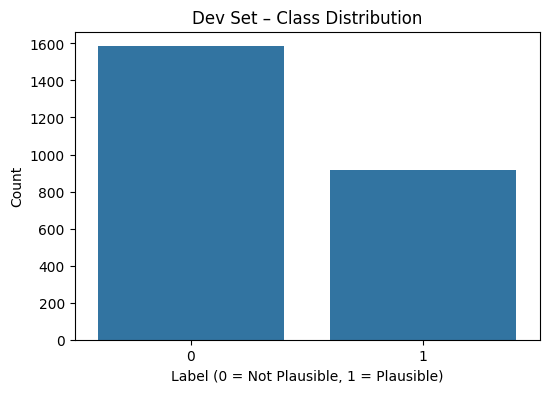

In [ ]:
#  Prepare Label Key (Id_FillerIndex)

train_labels_df.columns = ["Key", "LabelText"]
dev_labels_df.columns = ["Key", "LabelText"]

# Convert text labels → binary
train_labels_df["Label"] = train_labels_df["LabelText"].apply(lambda x: 1 if x == "PLAUSIBLE" else 0)
dev_labels_df["Label"] = dev_labels_df["LabelText"].apply(lambda x: 1 if x == "PLAUSIBLE" else 0)

# Build same Key in long tables
long_train["Key"] = long_train["Id"].astype(str) + "_" + long_train["FillerNum"].str.replace("Filler", "")
long_dev["Key"] = long_dev["Id"].astype(str) + "_" + long_dev["FillerNum"].str.replace("Filler", "")

# Merge labels
long_train = long_train.merge(train_labels_df[["Key", "Label"]], on="Key", how="left")
long_dev = long_dev.merge(dev_labels_df[["Key", "Label"]], on="Key", how="left")

print("Merged train shape:", long_train.shape)
print("Merged dev shape:", long_dev.shape)
print("Train label distribution:\n", long_train["Label"].value_counts())
print("Dev label distribution:\n", long_dev["Label"].value_counts())

# FIX: Remove missing labels (critical!)

missing_train = long_train[long_train["Label"].isna()]
missing_dev = long_dev[long_dev["Label"].isna()]

print("Missing labels in train:", missing_train.shape)
print("Missing labels in dev:", missing_dev.shape)

long_train = long_train.dropna(subset=["Label"])
long_dev = long_dev.dropna(subset=["Label"])

long_train["Label"] = long_train["Label"].astype(int)
long_dev["Label"] = long_dev["Label"].astype(int)

# CLASS DISTRIBUTION GRAPHS (TRAIN + DEV)

plt.figure(figsize=(6,4))
sns.countplot(x=long_train["Label"])
plt.title("Train Set – Class Distribution")
plt.xlabel("Label (0 = Not Plausible, 1 = Plausible)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=long_dev["Label"])
plt.title("Dev Set – Class Distribution")
plt.xlabel("Label (0 = Not Plausible, 1 = Plausible)")
plt.ylabel("Count")
plt.show()


In [ ]:

# Build final text input

def build_text(row):
    return f"{row['Previous context']} {row['Sentence']} {row['Follow-up context']} [SEP] {row['Candidate']}"

long_train["text"] = long_train.apply(build_text, axis=1)
long_dev["text"] = long_dev.apply(build_text, axis=1)

X = long_train["text"]
y = long_train["Label"]

X_dev_final = long_dev["text"]
y_dev_final = long_dev["Label"]

# Train/Validation Split for Experiments

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [ ]:
#  Define TF-IDF Feature Extractors

word_tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=2,
    max_features=20000
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2,
    max_features=15000
)

hybrid_tfidf = FeatureUnion([
    ("word", word_tfidf),
    ("char", char_tfidf)
])

#  Define Models

lr_balanced = LogisticRegression(max_iter=2000, class_weight="balanced")
svm_balanced = LinearSVC(class_weight="balanced")

ensemble = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=2000)),
        ("svm", LinearSVC())
    ],
    voting="hard"
)

#  Model Evaluation Helper
def run_model(title, features, clf):
    pipe = Pipeline([
        ("features", features),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)

    print(f"\n===== {title} =====")
    print("Accuracy:", round(acc, 3))
    print("F1 (class = PLAUSIBLE):", round(f1, 3))
    print(classification_report(y_val, preds, digits=3))

    return pipe, acc, f1



In [ ]:
# Run Experiments

results = []

pipe_lr_word, acc_lr, f1_lr = run_model(
    "Word TF-IDF + Logistic Regression", word_tfidf, lr_balanced
)
results.append(["Word + LR", acc_lr, f1_lr])

pipe_svm_word, acc_svm, f1_svm = run_model(
    "Word TF-IDF + SVM", word_tfidf, svm_balanced
)
results.append(["Word + SVM", acc_svm, f1_svm])

pipe_lr_char, acc_char, f1_char = run_model(
    "Char TF-IDF + LR", char_tfidf, lr_balanced
)
results.append(["Char + LR", acc_char, f1_char])

pipe_svm_hybrid, acc_hybrid, f1_hybrid = run_model(
    "Hybrid (Word+Char) TF-IDF + SVM", hybrid_tfidf, svm_balanced
)
results.append(["Hybrid + SVM", acc_hybrid, f1_hybrid])

pipe_ensemble, acc_ens, f1_ens = run_model(
    "Ensemble LR+SVM", word_tfidf, ensemble
)
results.append(["Ensemble", acc_ens, f1_ens])

#  Summary of Results

summary_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print("\n=== Summary of Experiments ===")
print(summary_df)




===== Word TF-IDF + Logistic Regression =====
Accuracy: 0.509
F1 (class = PLAUSIBLE): 0.397
              precision    recall  f1-score   support

           0      0.628     0.550     0.586      2525
           1      0.362     0.439     0.397      1466

    accuracy                          0.509      3991
   macro avg      0.495     0.494     0.491      3991
weighted avg      0.530     0.509     0.517      3991


===== Word TF-IDF + SVM =====
Accuracy: 0.521
F1 (class = PLAUSIBLE): 0.414
              precision    recall  f1-score   support

           0      0.640     0.557     0.595      2525
           1      0.376     0.460     0.414      1466

    accuracy                          0.521      3991
   macro avg      0.508     0.508     0.505      3991
weighted avg      0.543     0.521     0.529      3991


===== Char TF-IDF + LR =====
Accuracy: 0.508
F1 (class = PLAUSIBLE): 0.398
              precision    recall  f1-score   support

           0      0.628     0.546     0.584  


=== FINAL DEV SET EVALUATION: Hybrid TF-IDF + SVM ===
Dev Accuracy: 0.557
Dev F1 (PLAUSIBLE=1): 0.457
              precision    recall  f1-score   support

           0      0.673     0.585     0.626      1584
           1      0.414     0.508     0.457       915

    accuracy                          0.557      2499
   macro avg      0.544     0.547     0.541      2499
weighted avg      0.578     0.557     0.564      2499



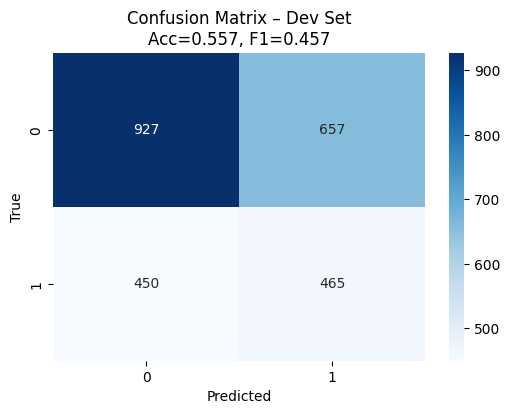

Saved dev predictions to: /content/results/dev_predictions.csv


In [ ]:
# FINAL DEV SET EVALUATION (BEST MODEL = Hybrid SVM)

print("\n=== FINAL DEV SET EVALUATION: Hybrid TF-IDF + SVM ===")
pipe_svm_hybrid.fit(X, y)
dev_preds = pipe_svm_hybrid.predict(X_dev_final)

dev_acc = accuracy_score(y_dev_final, dev_preds)
dev_f1 = f1_score(y_dev_final, dev_preds)

print("Dev Accuracy:", round(dev_acc, 3))
print("Dev F1 (PLAUSIBLE=1):", round(dev_f1, 3))
print(classification_report(y_dev_final, dev_preds, digits=3))

#  Confusion Matrix

cm = confusion_matrix(y_dev_final, dev_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – Dev Set\nAcc={dev_acc:.3f}, F1={dev_f1:.3f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save Output Predictions

os.makedirs("/content/results", exist_ok=True)

dev_output = pd.DataFrame({
    "Key": long_dev["Key"],
    "TrueLabel": y_dev_final,
    "PredictedLabel": dev_preds
})

dev_output.to_csv("/content/results/dev_predictions.csv", index=False)
print("Saved dev predictions to: /content/results/dev_predictions.csv")
